## SBA Loan Performance in Colorado##

The purpose of this notebook is to compile a dataset that will help us answer the questions:  

**1) What are the performance of SBA (small business administration) loans in Colorado in recent years?**  

**2) What are the factors that impact default rates of these loans?**

and ultimately,  

**3) Can we build a model that will predict if a SBA loan is going to default?**  


The goal of this notebook is to combine SBA loan performance data with (possibly) relevant data about Colorado gleaned from other sources, such as the governor's GoCodeColorado initiative.  

As with all notebooks, we start with importing several Python libraries and verifying our file location:

In [1]:
#Import related modules

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import requests

os.getcwd()

'C:\\Users\\David Olivero\\AnacondaProjects\\Loans-In-Colorado'

In [2]:
# Read csv file using chunks and add CO-specific rows into a new dataframe\n",
file = 'data\SBAnational.csv'

sba_reader = pd.read_csv(file, chunksize=5000)

co_data = pd.DataFrame()

for sba_chunk in sba_reader:
    sba_add = sba_chunk[sba_chunk['State'] == 'CO']
    co_data = co_data.append(sba_add)

sba_reader.close()

nRow, nCol = co_data.shape
print(f'There are {nRow} rows and {nCol} columns')
   

There are 20605 rows and 27 columns


We can see that 82% of this dataset contains loans that have been paid in full ('P I F'). The remaining 18% of the loans have been charged off, meaning the loan has defaulted:

In [3]:
print(co_data['MIS_Status'].value_counts([0]))

P I F     0.821779
CHGOFF    0.178221
Name: MIS_Status, dtype: float64


In [4]:
co_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20605 entries, 71 to 899122
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LoanNr_ChkDgt      20605 non-null  int64  
 1   Name               20605 non-null  object 
 2   City               20605 non-null  object 
 3   State              20605 non-null  object 
 4   Zip                20605 non-null  int64  
 5   Bank               20575 non-null  object 
 6   BankState          20575 non-null  object 
 7   NAICS              20605 non-null  int64  
 8   ApprovalDate       20605 non-null  object 
 9   ApprovalFY         20605 non-null  object 
 10  Term               20605 non-null  int64  
 11  NoEmp              20605 non-null  int64  
 12  NewExist           20603 non-null  float64
 13  CreateJob          20605 non-null  int64  
 14  RetainedJob        20605 non-null  int64  
 15  FranchiseCode      20605 non-null  int64  
 16  UrbanRural         2

## Reducing the timespan of the dataset ##
Overall this data set is not balanced, with way more "Paid In Full" loans than not, but that of course is reality. A 4.5:1 ratio should be acceptable for many machine learning techniques. 
Next, we look at the number of loans per year, to explore how well spread out the loans are in the full time span of the data set, which is roughly 5.5 decades:

In [5]:
loan_years = pd.DataFrame(co_data['ApprovalFY'].value_counts())
loan_years['Year'] = loan_years.index
loan_years['Year'] = pd.to_numeric(loan_years['Year'])
loan_years = loan_years.sort_values('Year', ascending=False)
loan_years.head()

,ApprovalFY,Year
2014,4,2014
2013,64,2013
2012,134,2012
2011,307,2011
2010,420,2010


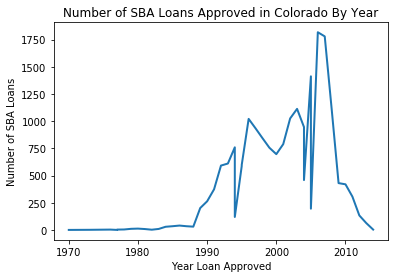

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(loan_years['Year'], loan_years['ApprovalFY'], linewidth=2)
plt.xlabel('Year Loan Approved')
plt.ylabel('Number of SBA Loans')
plt.title('Number of SBA Loans Approved in Colorado By Year')
plt.show()

Fortunately the data seems to be concentrated within a roughly 20 year time frame, from 1990 to 2010. With this observation, loans from prior to 1990 are dropped from the dataset. Two decades still covers a lot of history, though: 9/11, the dotcom crash of 2000, the 2008 recession, among other things.


In [7]:
# Based on this, we can eliminate all loan data prior to 1990:
co_data.ApprovalFY = pd.to_numeric(co_data.ApprovalFY)
co_data = co_data[co_data.ApprovalFY >= 1990]
co_data.shape

(20168, 27)

## How has loan repayment varied over time? ##
One question that arises: Are the good/bad ratio is relatively constant over time, or are there are significant changes in pass fail rate as a function of time?   
For example, as can be seen below, a significant increase in loan defaults occurs for loans originated in the ~2007 time frame. This is a fascinating result that precedes the great recession, and perhaps reflects the generally high loan default rates of that period (especially property mortgages).

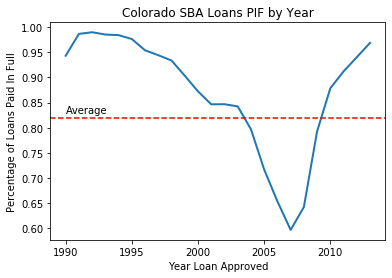

In [8]:
approved = pd.DataFrame()

for yr in range(1975,2014):
    data = co_data[co_data['ApprovalFY'] == yr]
    good = data['MIS_Status'].value_counts('P I F')
    approved = approved.append(good)
    
    
approved.index = range(1975,2014)

plt.plot(approved['P I F'], linewidth = 2.0)
plt.xlabel('Year Loan Approved')
plt.axhline(y=0.82, c='r', linestyle='--')
plt.annotate('Average', xy=(1990, 0.83))
plt.ylabel('Percentage of Loans Paid In Full')
plt.title('Colorado SBA Loans PIF by Year')
plt.show()

## Folding in county identification: Our index to add more data ##
Our next step is to fold in the information for counties, since most of the GoCode Colorado data is provided by county, and county is a nice, fairly small scale refinement of the dataset (There are 63 counties in Colorado). These are pulled from a list of US cities brought in as a CSV file. This city list does not include every single city within Colorado, but the vast majority, and all significantly sized ones. Hence there may a slight reduction in dataset size after inner joining this dataset to the loan dataset. Lastly, with the 'County_FIPS' and 'County_Name' columns, we'll have both numerical and string indices for the 63 counties; either can be used for merging future datasets. (In particular, county FIPS data is used to index county chloropleths, as will be seen later.)

In [9]:
os.getcwd()

'C:\\Users\\David Olivero\\AnacondaProjects\\Loans-In-Colorado'

In [10]:
# Preparation of county listing by city name or county fips code
# fips codes are used in a large number of GoCode Colorado files so may be a useful column to add. 

file = 'data\\uscities.csv'
county = pd.read_csv(file, usecols= ['city','state_id','county_fips','county_name'])
county = county[county['state_id']== 'CO'].reset_index(drop=True)
county.columns = county.columns.str.title()
county.head()


,City,State_Id,County_Fips,County_Name
0,Sanford,CO,8021,Conejos
1,Aurora,CO,8001,Adams
2,Avondale,CO,8101,Pueblo
3,Alpine,CO,8105,Rio Grande
4,Pitkin,CO,8051,Gunnison


In [11]:
county.shape

(455, 4)

In [12]:
# Change the 'City' column to the title string format to match the county dataframe.

co_data['City'] = co_data['City'].str.title()
#co_data.tail()

Inner join merge reduces the dataset from 20168 to 19372 rows, or about 4% reduction, which is acceptable. The merged dataframe is now ready to accept additional data based on county and year.

In [13]:
df = pd.merge(co_data, county, how = 'inner', on = 'City')
df.shape

(19372, 30)

In [14]:
# This creates a list of County FIPS values that matches the format in the geojson file for the choropleths:

df['County_Fips'] = df.County_Fips.astype(str)
df['County_Fips'] = ["0" + i for i in df['County_Fips'] ]


We can see below that the dataset is fairly heavy on a handful of counties. This makes sense, as the counties with many loans (e.g. Denver, Arapahoe, Boulder) are much higher in population. 

In [15]:
county_counts = df['County_Name'].value_counts()

county_counts.columns = ['NumLoans']
county_counts.head(20)

Denver        3647
Arapahoe      2046
El Paso       1977
Adams         1929
Jefferson     1556
Boulder       1380
Larimer       1078
Douglas        805
Weld           506
Mesa           445
Pueblo         434
La Plata       348
Broomfield     310
Eagle          293
Summit         282
Garfield       249
Montrose       156
Montezuma      149
Delta          137
Gunnison       133
Name: County_Name, dtype: int64

## Do different counties have different repayment rates? ##
Next, we explore the county by county variation in loan performance, using a dataframe called county_rates. A histogram of the overall percentage of repaid loans by county shows some spread in values, suggesting that how likely a loan is to be paid off may be partially a function of location in Colorado:

In [16]:
goodrate = pd.Series()

for i in range(0,63):
    c = county_counts.index[i]
    goodrate[c] = df[df['County_Name'] == c]['MIS_Status'].value_counts('P I F')[0]

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


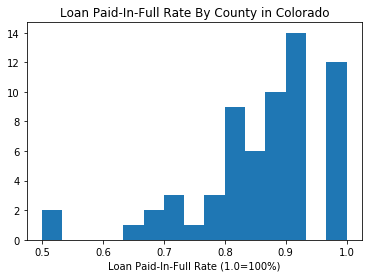

In [17]:
plt.hist(goodrate, bins=15)
plt.title('Loan Paid-In-Full Rate By County in Colorado')
plt.xlabel('Loan Paid-In-Full Rate (1.0=100%)')
plt.show()

In [18]:
goodrate['County'] = goodrate.index
county_counts['County'] = county_counts.index

In [19]:
county_rates = pd.concat([county_counts, goodrate], axis=1)

county_rates.columns = ['TotalLoansInCounty','PIF_RateByCounty']
county_rates['County_Name'] = county_rates.index

In [20]:
county_rates.head()

,TotalLoansInCounty,PIF_RateByCounty,County_Name
Denver,3647,0.839232,Denver
Arapahoe,2046,0.797654,Arapahoe
El Paso,1977,0.819838,El Paso
Adams,1929,0.752722,Adams
Jefferson,1556,0.821979,Jefferson


In [21]:
# Add the loan repayment rate and number of loans per county data to the dataframe df:

df = pd.merge(df, county_rates, how = 'left', on = 'County_Name')

In [22]:
PIF = df[['County_Fips','PIF_RateByCounty']].drop_duplicates().reset_index(drop=True)

In [23]:
PIF.head()

,County_Fips,PIF_RateByCounty
0,08077,0.876404
1,08101,0.870968
2,08001,0.752722
3,08117,0.879433
4,08067,0.913793


## Adding Data: Personal Income (and Population) from GoCode Colorado##
GoCode Colorado is an initiative put forth by Governor Jared Polis to make available certain datasets to developers, in the hopes this data can be put to use. We'll first look at the Personal income dataset from GoCode Colorado, to clean, parse and fold into the County dataset:

In [24]:
# Personal income dataset from GoCode Colorado

file1 = 'data\\Personal_income_in_Colorado.csv'

income = pd.read_csv(file1, usecols=['areaname', 'periodyear', 'incdesc', 'income','population' ])

# Wrangle and tidy dataset for use:

income = income[income['areaname'].str.endswith('County')]    # <------ Discard all non-county rows
income = income[income['periodyear'] >= 1990]                 # <------ Discard all dates prior to 1990
income = income[income['incdesc'].str.startswith('Per')]      # <------ Discard Total and Median values (only per cap)

income.head()


,areaname,periodyear,incdesc,income,population
394,Adams County,1990,Per Capita Personal Income - Bureau of Economi...,16192,266629.0
397,Adams County,1991,Per Capita Personal Income - Bureau of Economi...,16647,274311.0
399,Adams County,1992,Per Capita Personal Income - Bureau of Economi...,17538,284362.0
401,Adams County,1993,Per Capita Personal Income - Bureau of Economi...,18393,293995.0
404,Adams County,1994,Per Capita Personal Income - Bureau of Economi...,19262,302197.0


A little cleanup of column information in the reduced dataframe. Remove the "County" in areaname, shorten the incdesc column string, and rename columns to better names and a Title format.

In [25]:
income['areaname'] = income['areaname'].str.replace(' County', '') # <------Match County Name format
income = income.drop(columns = ['incdesc'])                        # <------unneeded descriptive column
income.columns = ['County', 'Year', 'MedIncome', 'Population']     # <------Match title format and useful names
income.reset_index()
income.head()

,County,Year,MedIncome,Population
394,Adams,1990,16192,266629.0
397,Adams,1991,16647,274311.0
399,Adams,1992,17538,284362.0
401,Adams,1993,18393,293995.0
404,Adams,1994,19262,302197.0


Aggregating this dataframe to look at the maximum (of the Median) Per Capita Personal income across all counties in Colorado shows a significant spread:

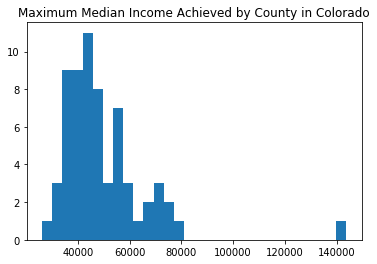

In [26]:
maxPC = income.groupby(by = 'County').agg(max)
plt.hist(maxPC['MedIncome'], bins=30)
plt.title('Maximum Median Income Achieved by County in Colorado')
plt.show()

## Some counties are growing, some aren't ###
Since we have median income and population data for all years in this dataframe, will be interesting to look at how those numbers have shifted for different counties. Next we want to aggregate the data with a calculation for how much the population in each county has increased over a given time period. Here, we will say from 1995 to 2010:

In [27]:
# Years can be modified here if needed in future. Year 1 is beginning year and year 2 is ending year
year1 = 1995
year2 = 2010

# Create a couple dataframes subsetted for the two years declared above, called df1 and df2

df1 = income.loc[income['Year'] == year1].reset_index()
df2 = income.loc[income['Year'] == year2].reset_index()


In [28]:
# Create another new dataframe, called dif, to store the change in population from year1 to year2

dif = pd.DataFrame()

dif['County'] = df1['County']

dif['PopChange'] = (df2['Population'].subtract(df1['Population'])) / df2['Population']
dif.head()

,County,PopChange
0,Adams,0.293547
1,Alamosa,0.097576
2,Arapahoe,0.222551
3,Archuleta,0.411248
4,Baca,-0.188918


The histogram below shows how the population of each county has changed from year 1 to year 2, normalized by the population in year 2 (2010). 

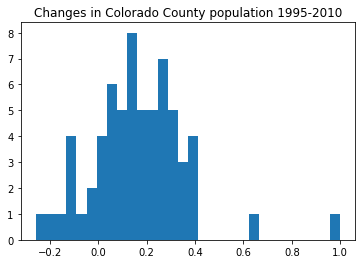

In [29]:
plt.hist(dif['PopChange'], bins=30)
plt.title('Changes in Colorado County population 1995-2010')
plt.show()

In [30]:
# Since we went to the trouble to create the population change values, 
# Add this to the original income dataframe prior to incorporating it into the main dataset

income = pd.merge(income, dif, how = 'left', on = 'County')

In [31]:
income.head()

,County,Year,MedIncome,Population,PopChange
0,Adams,1990,16192,266629.0,0.293547
1,Adams,1991,16647,274311.0,0.293547
2,Adams,1992,17538,284362.0,0.293547
3,Adams,1993,18393,293995.0,0.293547
4,Adams,1994,19262,302197.0,0.293547


Now we want to merge the new income dataframe into the loans dataframe based on both year and county:

In [32]:
df = pd.merge(df, income, how = 'left', left_on=['County_Name','ApprovalFY'], right_on=['County','Year'])

In [33]:
df.tail()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,State_Id,County_Fips,County_Name,TotalLoansInCounty,PIF_RateByCounty,County,Year,MedIncome,Population,PopChange
19367,8771344008,DAHL-HOUSE CONSTRUCTION,Indian Hills,CO,80454,U.S. BANK NATIONAL ASSOCIATION,OH,238110,7-Apr-05,2005,...,CO,08059,Jefferson,1556,0.821979,Jefferson,2005,41754,519675.0,0.081159
19368,8955463007,CRYSTAL STIX,Moffat,CO,81143,VECTRA BK COLORADO NATL ASSOC,NM,339920,24-Jan-96,1996,...,CO,08109,Saguache,12,1,Saguache,1996,15121,5413.0,0.152379
19369,9253773006,ROMEO LIQUORS,Romeo,CO,81148,VECTRA BK COLORADO NATL ASSOC,NM,445310,6-May-96,1996,...,CO,08021,Conejos,8,1,Conejos,1996,13819,7995.0,0.048722
19370,9497963000,SKC ACCOUNTING SERVICES,Holly,CO,81047,VALLEY NATL BANK A BRANCH OF,CO,0,29-Aug-96,1996,...,CO,08099,Prowers,15,0.8,Prowers,1996,18021,14046.0,-0.110333
19371,9597073001,"TINY'S COUNTRY STORE, INC.",Granada,CO,81041,SCEDD DEVELOPMENT COMPANY,CO,0,30-Sep-96,1996,...,CO,08099,Prowers,15,0.8,Prowers,1996,18021,14046.0,-0.110333


## Adding Data: Employment and Unemployment by County, from GoCode Colorado ##
Another dataset made available as part of GoCodeColorado is the labor department data for employment and unemployment as a function of county and year. We'll pull this in and glean potentially impactful features from this dataset.

In [34]:
file_unemp = 'data\\Unemployment_Estimates_in_Colorado.csv'

employ = pd.read_csv(file_unemp, usecols=['areaname', 'periodyear', 'pertypdesc','laborforce', 'emplab','unemp','unemprate' ])

# Wrangle and tidy dataset for use:

employ = employ[employ['areaname'].str.endswith('County')]    # <------ Discard all non-county rows
employ = employ[employ['periodyear'] >= 1990]                 # <------ Discard all dates prior to 1990
employ = employ[employ['pertypdesc'] == 'Annual']             # <------ Discard all monthly data

employ.head()

,areaname,periodyear,pertypdesc,laborforce,emplab,unemp,unemprate
711,Adams County,1990,Annual,140544,132385,8159,5.8
724,Adams County,1991,Annual,142002,134516,7486,5.3
737,Adams County,1992,Annual,145671,137195,8476,5.8
750,Adams County,1993,Annual,150890,142831,8059,5.3
763,Adams County,1994,Annual,158763,151849,6914,4.4


In [35]:
# Drop unneeded columns and rename others to match title case and create more meaningful column names

employ['areaname'] = employ['areaname'].str.replace(' County', '')
employ = employ.drop(columns = ['pertypdesc'])
employ.columns = ['County', 'Year', 'LaborForceInCty', 'EmployedInCty','UnempInCty','UnempRateInCty']
employ.reset_index(drop=True)

,County,Year,LaborForceInCty,EmployedInCty,UnempInCty,UnempRateInCty
0,Adams,1990,140544,132385,8159,5.8
1,Adams,1991,142002,134516,7486,5.3
2,Adams,1992,145671,137195,8476,5.8
3,Adams,1993,150890,142831,8059,5.3
4,Adams,1994,158763,151849,6914,4.4
...,...,...,...,...,...,...
1915,Elbert,2018,15034,14628,406,2.7
1916,Lake,2016,4613,4481,132,2.9
1917,Kit Carson,2016,4534,4438,96,2.1
1918,Baca,2019,2175,2138,37,1.7


In [36]:
df = pd.merge(df, employ, how = 'left', left_on=['County_Name','ApprovalFY'], right_on=['County','Year'])

## Adding Data: CDC All-Cause Mortality ##
Here we'll start working with CDC Mortality Data from CDC WONDER database. Specifically, we'l focus on gleaning the all-cause mortality rates by county. The theory behind including this feature in our model is that mortality may be an indicator of the age of population, affluence, disposible income, and general health, which may play a role in whether or not businesses in these communities can succeed or not. To this end, we pull the Compressed_Mortality file off the CDC WONDER database:

In [37]:
# Read output from WONDER database query: Death rates by county for the year 2000

file = 'data\\Compressed_Mortality.txt'

with open(file, 'r') as dat:
    lines = dat.readlines()
    
dat.close()

In [38]:
# Convert the read lines into a list of lists

mortal_list = []

for line in lines:
    linelist = line.strip('\n').split('\t')
    linelist[1] = linelist[1][1:-12]
    linelist[2] = linelist[2][1:-1]
    mortal_list.append(linelist)

In [39]:
# Convert the list object into a dataframe, with header information

mortal = pd.DataFrame(mortal_list)

new_header = mortal.iloc[0]                    # <-------------grab the first row for the header
mortal = mortal[1:]                            # <-------------take the data less the header row
mortal.columns = new_header                    # <-------------set the header row as the df header

In [40]:
# For now, just keep the deaths per 100,000 people statistic for each county:

mortal = mortal.drop(columns = ['Deaths', 'Population', '% of Total Deaths'])
mortal.head()

,,,County Code,Crude Rate
1,,Baca,08009,1372.6
2,,Phillips,08095,1294.6
3,,Las Animas,08071,1190.2
4,,Otero,08089,1157.0
5,,Costilla,08023,1146.6


In [41]:
# There is still a "dummy" column in the DataFrame, an artifact of the way we split the strings
mortal.columns

Index(['', '', 'County Code', 'Crude Rate'], dtype='object', name=0)

In [42]:
# Rename columns to appropriate title formats
# Eliminate "Dummy" column so it doesn't get merged

mortal.columns = ['Dummy','County', 'County_Fips', 'DeathsPer100k']
mortal = mortal.drop(columns = ['Dummy', 'County_Fips'])
mortal.head()

,County,DeathsPer100k
1,Baca,1372.6
2,Phillips,1294.6
3,Las Animas,1190.2
4,Otero,1157.0
5,Costilla,1146.6


In [43]:
df = pd.merge(df, mortal, how = 'left', left_on=['County_Name'], right_on=['County'])

## ...And Finally, Some Housecleaning of the Main Dataset ##
Here we'll remove columns we don't need, and make sure that columns that remain are in data types that are useful.

In [44]:
# First step is to remove redundant or single-value columns from merges
df = df.drop(columns = ['County', 'Year_y', 'County_x', 'Year_x', 'County_y', 'State_Id', 'State'])

# Also drop columns that don't code useful info, like zip codes and loan numbers
df = df.drop(columns = ['LoanNr_ChkDgt', 'Zip'])

We will do more data cleaning later, but for now the dataset is looking pretty decent, with unique columns, each with potentially useful information. 

## EDA: How does PIF rate vary with loan size? ##
The following section deals with getting the loan repayment rate as a function of the size of the loan, across the entire Colorado dataset. We'll do this using the "DisbursementGross" column from the SBA loan dataset. 

In [45]:
# Convert DisbursementGross column to numeric

df['DisbursementGross'] = df['DisbursementGross'].apply(lambda x: x.replace('$','')).apply(lambda x: x.replace(',','')).astype(np.float)


We can see in the histogram plot below that loan size distribution appears to be somewhat exponential or Poisson in shape, with the majority of loans being small loans.  

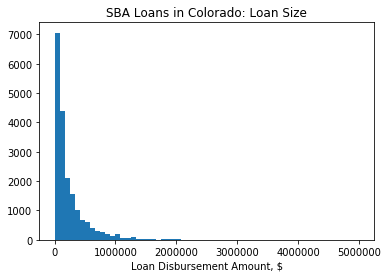

In [46]:
plt.hist(df['DisbursementGross'], bins = 60)
plt.xlabel('Loan Disbursement Amount, $')
plt.title('SBA Loans in Colorado: Loan Size')
plt.show()

In [47]:
# We start by creating a list representing the bin limits for the loan size data.
# For starters we will bins loans in increments of $50,000.

binz = [50000 * x for x in list(range(0,20))]
print(binz)
   

[0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000, 650000, 700000, 750000, 800000, 850000, 900000, 950000]


In [48]:
# Create a dictionary object that, for each element in binz, stores an associated PIF rate:
PIF_CI = dict()
bin_qty = dict()

for i in binz[0:-1]:
    sub_df = df[(df['DisbursementGross'] > i) & (df['DisbursementGross'] <= (i+50000))]
    good_loans = sub_df['MIS_Status'].value_counts('P I F')[0]
    PIF_CI[i] = 1.96*np.sqrt(good_loans*(1-good_loans)/len(sub_df))
    bin_qty[i] = good_loans

In [49]:
print(bin_qty)

{0: 0.7541053529537215, 50000: 0.7830620549338759, 100000: 0.8087748344370861, 150000: 0.8676569885212694, 200000: 0.8669950738916257, 250000: 0.8827361563517915, 300000: 0.8898186889818689, 350000: 0.8867924528301887, 400000: 0.9244851258581236, 450000: 0.9190283400809717, 500000: 0.9096774193548387, 550000: 0.9233449477351916, 600000: 0.9, 650000: 0.9237668161434978, 700000: 0.917098445595855, 750000: 0.8794326241134752, 800000: 0.8363636363636363, 850000: 0.8818181818181818, 900000: 0.9555555555555556}


In [50]:
print(PIF_CI)

{0: 0.012321614545149014, 50000: 0.012882945443479291, 100000: 0.01568172898093708, 150000: 0.017258501438762272, 200000: 0.019071050022282373, 250000: 0.0207789585430247, 300000: 0.022919293327347063, 350000: 0.02462499767080223, 400000: 0.02477316917233152, 450000: 0.02405600858400248, 500000: 0.031909287019613854, 550000: 0.030779921198581296, 600000: 0.03877157183567227, 650000: 0.03483027052842518, 700000: 0.03890153446603476, 750000: 0.0537480491512126, 800000: 0.06913487944027702, 850000: 0.06032878611624764, 900000: 0.04257665402264554}


In [51]:
# Subsequently convert the dictionary object into a DataFrame

PIF_by_size = pd.DataFrame(bin_qty.items(), columns=['Loan', 'PIF_Rate'])
PIF_by_size.head()

,Loan,PIF_Rate
0,0,0.754105
1,50000,0.783062
2,100000,0.808775
3,150000,0.867657
4,200000,0.866995


In [52]:
PIF_by_size = pd.merge(PIF_by_size, pd.DataFrame(PIF_CI.items(), columns=['Loan', 'CI']), how='left', on='Loan')

In [53]:
PIF_by_size['LowerCI'] = PIF_by_size['PIF_Rate'] - PIF_by_size['CI']
PIF_by_size['UpperCI'] = PIF_by_size['PIF_Rate'] + PIF_by_size['CI']
PIF_by_size.head()

,Loan,PIF_Rate,CI,LowerCI,UpperCI
0,0,0.754105,0.012322,0.741784,0.766427
1,50000,0.783062,0.012883,0.770179,0.795945
2,100000,0.808775,0.015682,0.793093,0.824457
3,150000,0.867657,0.017259,0.850398,0.884915
4,200000,0.866995,0.019071,0.847924,0.886066


We can see in the plot below that small loans seem to get paid back less than larger ones, no doubt this will be a useful insight in our model creation. There seems to be a dip in loan performance for loans about $800,000 in size, however this may be spurious given the relatively wide confidence interval band at this loan size (see plot below):

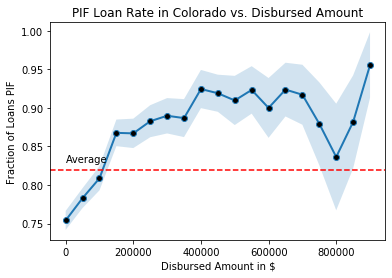

In [54]:
plt.plot(PIF_by_size['Loan'], PIF_by_size['PIF_Rate'], linestyle='-', marker='o', markerfacecolor='black', linewidth = 2)
plt.fill_between(PIF_by_size['Loan'],PIF_by_size['LowerCI'],PIF_by_size['UpperCI'], alpha=0.2)
plt.axhline(y=0.82, c='r', ls='--')
plt.annotate('Average', xy=(0, 0.83))
plt.xlabel('Disbursed Amount in $')
plt.ylabel('Fraction of Loans PIF')
plt.title('PIF Loan Rate in Colorado vs. Disbursed Amount')
plt.show()

## EDA: How does PIF rate vary with loan term? ##
The following section deals with getting the loan repayment rate as a function of the term of the loan, across the entire Colorado dataset. We'll do this using the "Term" column from the SBA loan dataset. 

In [55]:
# We start by creating a list representing the bin limits for the loan term data.
# For starters we will bins loans in increments of 10 months, from 0 to 240 months.

binz = [10 * x for x in list(range(0,25))]
print(binz)
   

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240]


In [56]:
# Create a dictionary object that, for each element in binz, stores an associated PIF rate:
bin_qty = dict()
PIF_CI = dict()

for i in binz[0:-1]:
    sub_df = df[(df['Term'] > i) & (df['Term'] <= (i+10))]
    good_loans = sub_df['MIS_Status'].value_counts('P I F')[0]
    PIF_CI[i] = 1.96*np.sqrt(good_loans*(1-good_loans)/len(sub_df))
    bin_qty[i] = good_loans

In [57]:
# Subsequently convert the dictionary object into a DataFrame. Merge it with CI dataframe
# and create columns for upper and lower CI

PIF_by_term = pd.DataFrame(bin_qty.items(), columns=['Term', 'PIF_Rate'])
PIF_by_term = pd.merge(PIF_by_term, pd.DataFrame(PIF_CI.items(), columns=['Term', 'CI']), how='left', on='Term')
PIF_by_term['LowerCI'] = PIF_by_term['PIF_Rate'] - PIF_by_term['CI']
PIF_by_term['UpperCI'] = PIF_by_term['PIF_Rate'] + PIF_by_term['CI']

We can see in the plot below that there doesn't seem to be a strong trend with loan term. That said, it's worth noting that all  loans below 60 months' term seem to preform consistently worse on average compared to longer term loans. 

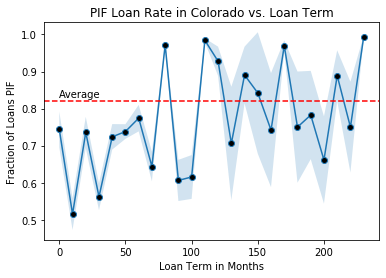

In [58]:
plt.plot(PIF_by_term['Term'], PIF_by_term['PIF_Rate'], linestyle='-', marker='o', markerfacecolor='black')
plt.fill_between(PIF_by_term['Term'],PIF_by_term['LowerCI'],PIF_by_term['UpperCI'], alpha=0.2)
plt.axhline(y=0.82, c='r', ls='--')
plt.annotate('Average', xy=(0, 0.83))
plt.xlabel('Loan Term in Months')
plt.ylabel('Fraction of Loans PIF')
plt.title('PIF Loan Rate in Colorado vs. Loan Term')
plt.show()

## Data Exploration: PIF Rate By County ## 
We see large variations in PIF Rate by county, which on the surface seems like an enormously significant result. However, we also see large variations in sample size from one county ot the next; specifically, very small counties have very few loans associated with them.  
To explore this further, we generate a **"Funnel Plot"** of the Loan PIF Rate by county as a function of how many loans are in each county:

In [59]:
# Pull the relevant data into a separate dataframe

spread = df[['TotalLoansInCounty', 'PIF_RateByCounty']].drop_duplicates().reset_index(drop=True).sort_values('TotalLoansInCounty')

In [60]:
spread['GoodLoans'] = spread['TotalLoansInCounty'] * spread['PIF_RateByCounty']

mean_y = spread['GoodLoans'].sum() / spread['TotalLoansInCounty'].sum()

spread.head()

,TotalLoansInCounty,PIF_RateByCounty,GoodLoans
51,1,1,1
59,2,0.5,1
58,4,1,4
53,5,0.8,4
56,6,1,6


In [61]:
spread['GoodLoans'] = pd.to_numeric(spread['GoodLoans'] )
spread['TotalLoansInCounty'] = pd.to_numeric(spread['TotalLoansInCounty'] )
spread['PIF_RateByCounty'] = pd.to_numeric(spread['PIF_RateByCounty'] )
spread.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 51 to 5
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   TotalLoansInCounty  60 non-null     int64  
 1   PIF_RateByCounty    60 non-null     float64
 2   GoodLoans           60 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.9 KB


In [62]:
spread['LowerCI'] = mean_y - 1.96*np.sqrt(mean_y*(1-mean_y)/spread['TotalLoansInCounty'])
spread['UpperCI'] = mean_y + 1.96*np.sqrt(mean_y*(1-mean_y)/spread['TotalLoansInCounty'])


The resulting funnel plot, with a 95% confidence interval shaded, suggests that while some of the variability we see in PIF rate by county may be due to variance inherent in low sample size, there are some counties that seem to deviate significantly from the variance predicted by the funnel plot:

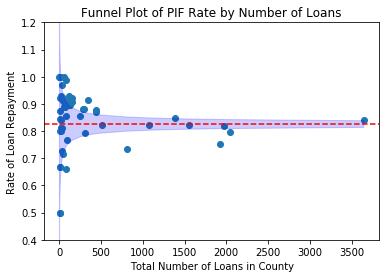

In [63]:
plt.scatter(spread['TotalLoansInCounty'], spread['PIF_RateByCounty'])
plt.fill_between(spread['TotalLoansInCounty'], spread['LowerCI'], spread['UpperCI'], color='blue',alpha=0.2)
plt.axhline(mean_y, xmin=0, xmax=4000, linestyle = '--', c='r')
plt.title('Funnel Plot of PIF Rate by Number of Loans')
plt.xlabel('Total Number of Loans in County')
plt.ylabel('Rate of Loan Repayment')
plt.ylim([0.4, 1.2])
plt.show()

With much of the data wrangled and explored, we export a new csv file representing the work done so far:

In [64]:
# Write the resulting DataFrame to csv for storage for later use. 

file_name = 'data\\SBA_Model_Input.csv'
df.to_csv(file_name, encoding='utf-8', index=False)